In [1]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from IPython.display import clear_output # 清空单元格输出区域
import matplotlib.pyplot as plt
# %matplotlib inline


In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
env_name = "CartPole-v0"
env = gym.make(env_name)

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

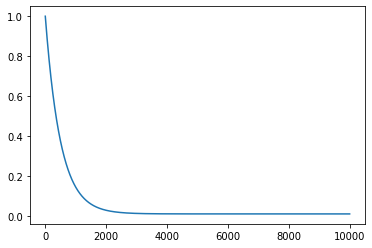

In [6]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Dueling DQN 网络

DQN等算法中使用的是一个简单的三层神经网络：一个输入层，一个隐藏层和一个输出层。如下左图：

<img src="assets/task0_train_20211112021954.png" alt="image-20211112022028670" style="zoom:50%;" />

而在Dueling DQN中，我们在后面加了两个子网络结构，分别对应上面上到价格函数网络部分和优势函数网络部分。对应上面右图所示。最终Q网络的输出由价格函数网络的输出和优势函数网络的输出线性组合得到。

我们可以直接使用上一节的价值函数的组合公式得到我们的动作价值，但是这个式子无法辨识最终输出里面$V(S, w, \alpha)$和$A(S, A, w, \beta)$各自的作用，为了可以体现这种可辨识性(identifiability),实际使用的组合公式如下：

$$
Q(S, A, w, \alpha, \beta)=V(S, w, \alpha)+\left(A(S, A, w, \beta)-\frac{1}{\mathcal{A}} \sum_{a^{\prime} \in \mathcal{A}} A\left(S, a^{\prime}, w, \beta\right)\right)
$$

In [7]:
class DuelingNet(nn.Module):
    def __init__(self, n_states, n_actions,hidden_size=128):
        super(DuelingNet, self).__init__()
        
        # 隐藏层
        self.hidden = nn.Sequential(
            nn.Linear(n_states, hidden_size),
            nn.ReLU()
        )
        
        # 优势函数
        self.advantage = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
        
        # 价值函数
        self.value = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        x = self.hidden(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [8]:
class DuelingDQN:
    def __init__(self,n_states,n_actions,cfg) -> None:
        self.batch_size = cfg.batch_size
        self.device = cfg.device
        self.loss_history = [] # 记录loss的变化
        self.frame_idx = 0  # 用于epsilon的衰减计数
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
            (cfg.epsilon_start - cfg.epsilon_end) * \
            math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.policy_net = DuelingNet(n_states, n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = DuelingNet(n_states, n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): # 复制参数到目标网络targe_net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # 优化器
        self.memory = ReplayBuffer(cfg.memory_capacity) 
    def choose_action(self,state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 选择Q值最大的动作
        else:
            action = random.randrange(self.n_actions)
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        state, action, reward, next_state, done = self.memory.sample(batch_size)
        state = torch.tensor(state, device=self.device, dtype=torch.float)
        action = torch.tensor(action, device=self.device).unsqueeze(1)  
        reward = torch.tensor(reward, device=self.device, dtype=torch.float)  
        next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)
        done = torch.tensor(np.float32(done), device=self.device)
        q_values      = self.policy_net(state)
        next_q_values = self.target_net(next_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)
        
        loss = (q_value - expected_q_value.detach()).pow(2).mean()
        self.loss_history.append(loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
current_model = DuelingNet(env.observation_space.shape[0], env.action_space.n)
target_model  = DuelingNet(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [10]:

def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [11]:

update_target(current_model, target_model)

In [12]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
def plot(frame_idx, rewards, losses):
    clear_output(True) # 清空单元格输出区域，因为多次打印，每次需要清楚前面打印的图片
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

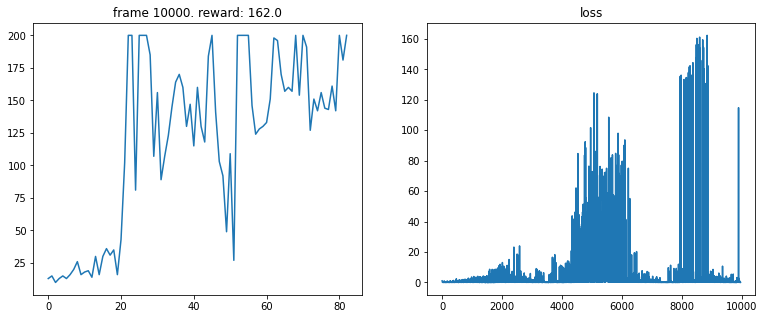

In [14]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
ep_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    ep_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(ep_reward)
        ep_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)


## 参考

[强化学习(十二) Dueling DQN](https://www.cnblogs.com/pinard/p/9923859.html)